In [92]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import plotly.express as px

In [93]:
# 1. 하나 은행의 주가 데이터를 크롤링을 이용해 수집하시오. (25년 데이터만 수집) 

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from io import StringIO

url = 'https://finance.naver.com/item/sise_day.naver?code=086790&page='
dic = {"User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 14_3_1)"}

url_data = requests.get(url + '1', headers = dic)
pd.read_html(StringIO(url_data.text))[0]

,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025.06.13,78200.0,"상승 1,000",77900.0,78800.0,77000.0,876131.0
2,2025.06.12,77200.0,하락 600,76400.0,77750.0,76100.0,2180729.0
3,2025.06.11,77800.0,하락 500,77400.0,78300.0,75800.0,1167594.0
4,2025.06.10,78300.0,상승 700,78100.0,80800.0,77000.0,1680784.0
5,2025.06.09,77600.0,"상승 4,100",74500.0,77600.0,74000.0,1670019.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2025.06.05,73500.0,"하락 1,000",73200.0,74700.0,73200.0,1151217.0


In [94]:
df_hana_stack = pd.DataFrame()

for i in tqdm(range(1, 12)):
    url_data = requests.get(url + str(i), headers = dic)
    df = pd.read_html(StringIO(url_data.text))[0]
    df_hana_stack = pd.concat([df_hana_stack, df])

df01 = df_hana_stack.dropna()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.60it/s]


In [95]:
df01

,날짜,종가,전일비,시가,고가,저가,거래량
1,2025.06.13,78200.0,"상승 1,000",77900.0,78800.0,77000.0,876131.0
2,2025.06.12,77200.0,하락 600,76400.0,77750.0,76100.0,2180729.0
3,2025.06.11,77800.0,하락 500,77400.0,78300.0,75800.0,1167594.0
4,2025.06.10,78300.0,상승 700,78100.0,80800.0,77000.0,1680784.0
5,2025.06.09,77600.0,"상승 4,100",74500.0,77600.0,74000.0,1670019.0
...,...,...,...,...,...,...,...
9,2025.01.03,57000.0,상승 200,57100.0,58000.0,57000.0,530060.0
10,2025.01.02,56800.0,보합0,56900.0,58100.0,56600.0,564964.0
11,2024.12.30,56800.0,하락 800,57800.0,58300.0,56800.0,509855.0
12,2024.12.27,57600.0,하락 700,57500.0,58000.0,57100.0,779839.0


In [96]:
df01['date'] = pd.to_datetime(df01['날짜'])
cond1 = df01['date'] >= pd.to_datetime('2025-01-01')
df_hana = df01.loc[cond1].sort_values(by = 'date')
df_hana.to_csv('hana_stock.csv')

C:\Users\leedo\AppData\Local\Temp\ipykernel_1680\2712574863.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
# 2. 수집된 데이터의 일자 별 시가에 대해 시각화를 수행하시오. 

px.line(df_hana, x = 'date', y = '시가')

In [98]:
# 3. 수집한 데이터의 시가에 대한 정상성 검정을 수행하시오. 

from statsmodels.tsa.stattools import adfuller

# 귀무가설: 해당 연속형 자료는 정상성을 따르지 않는다
# 대립가설: 해당 연속형 자료는 정상성을 따른다

adfuller(df_hana['시가'])
# 해당 연속형 자료는 정상성을 따르지 않는다.

(1.204514340210595,
 0.9960169250415192,
 0,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 1561.314222159676)

In [99]:
# 4. 정상성을 만족하지 않는다고 가정하여, 계절성 변환(Classical & STL) 및 차분을 수행하시오. 

# 계절성 제거
from statsmodels.tsa.seasonal import seasonal_decompose

# 계절성 분해
result = seasonal_decompose(df_hana['시가'], period=7) # 7일을 기준으로 계절성을 분해
df_hana['시가_add'] = df_hana['시가'] - result.seasonal
adfuller(df_hana['시가_add'])
# 해당 변환을 수행한 결과, 시가 데이터의 변환 결과는 정상성을 따르지 않는다.

(0.9273680860404309,
 0.9934372923397579,
 10,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 1554.7860985259285)

- ADF검정은 pvalue를 계산하는 함수식이 비대칭성을 갖기 때문에 시간의 순서가 중요하다
- kpss(kwiatkowski-phillips-schmidt-sin) test
  - 귀무가설: 해당 연속형 자료는 정상성을 따른다
  - 대립가설: 해당 연속형 자료는 정상성을 따르지 않는다.
  - 양측 검정(데이터의 나열 순서에 상관없이 검정이 가능)
  - ADF검정에 비해 부정확 할 수 있다.

In [100]:
from statsmodels.tsa.stattools import kpss

# 귀무가설: 해당 연속형 자료는 정상성을 따른다
# 대립가설: 해당 연속형 자료는 정상성을 따르지 않는다.

kpss(df_hana['시가'], nlags='auto', regression='c')
# regression = 'c' : 수평 정상성을 따르는가, 'ct' = 추세 정상성에 대한 확인
# pvalue < 0.05 -> 대립가설 참 -> 정상성을 따르지 않는다.

C:\Users\leedo\AppData\Local\Temp\ipykernel_1680\373587483.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(0.9717228854097406,
 0.01,
 5,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [101]:
# 차분을 수행하여 검정

df_hana['시가_diff'] = df_hana['시가'].diff()
px.line(df_hana, x = 'date', y = '시가_diff')

In [102]:
# ADF test

adfuller(df_hana['시가_diff'].dropna())
# 대립가설 참 -> 정상성을 따른다

(-10.08131510563977,
 1.1865422375781314e-17,
 0,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 1546.019467847449)

In [103]:
# 5. 시간 데이터를 연/월/일/요일로 파생 변수를 생성하고, 다음과 같은 X를 넣었을 때, 종가를 예측하는 모델을 구성하시오.
#     - X : 연도/월/일/요일/거래량
#     - Y : 종가
#     - 앙상블 모델 활용 / Feature Importance 확인 / 모델을 파일 저장

df_hana['year'] = df_hana['date'].dt.year
df_hana['month'] = df_hana['date'].dt.month
df_hana['day'] = df_hana['date'].dt.day
df_hana['weekday'] = df_hana['date'].dt.day_name()
df_hana.head(2)


,날짜,종가,전일비,시가,고가,저가,거래량,date,시가_add,시가_diff,year,month,day,weekday
10,2025.01.02,56800.0,보합0,56900.0,58100.0,56600.0,564964.0,2025-01-02,56744.081633,NaN,2025,1,2,Thursday
9,2025.01.03,57000.0,상승 200,57100.0,58000.0,57000.0,530060.0,2025-01-03,57455.306122,200.0,2025,1,3,Friday


In [104]:
from sklearn.model_selection import train_test_split

x = df_hana[['year', 'month', 'day', 'weekday', '거래량']]
y = df_hana['종가']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)

In [105]:
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [106]:
pipe1 = make_pipeline(SimpleImputer(strategy='median'))
pipe2 = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
pipe3 = make_column_transformer((pipe1, ['year', 'month', 'day', '거래량']), (pipe2, ['weekday']))
model_pipe = make_pipeline(pipe3, RandomForestRegressor())
model_pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['year', 'month', 'day',
                                                   '거래량']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weekday'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [107]:
hyper = {'randomforestregressor__max_depth':[2, 3, 5],
        'randomforestregressor__n_estimators':[200]}
grid_model = GridSearchCV(model_pipe, param_grid=hyper, cv = 3, n_jobs=-1, scoring='r2')
grid_model.fit(x_train, y_train)
best_model = grid_model.best_estimator_

In [108]:
# 변수 중요도 확인
df_importance = pd.DataFrame()
df_importance['x'] = best_model['columntransformer'].get_feature_names_out()
df_importance['value'] = best_model['randomforestregressor'].feature_importances_

In [109]:
px.bar(df_importance, x = 'value', y = 'x')

In [110]:
from sklearn.metrics import r2_score, mean_squared_error

y_test_pred = best_model.predict(x_test)
print(r2_score(y_test, y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

0.8504526967622071
4953534.01256943


In [111]:
import pickle
pickle.dump(best_model, open('model_tsa.sav', 'wb'))

**Naive Model**: 시계열 상의 이전 값의 데이터를 이용하여 다음 일자의 데이터를 예측하는 모형

In [112]:
# 데이터프레임구조를 darts 라이브러리 내 예측 모형에 쓸 수 있도록 데이터 구조를 변환
from darts import TimeSeries
from darts.models import NaiveSeasonal

In [113]:
# 일단위로 time series를 darts 사용할 수 있는 구조로 변환
series1 = TimeSeries.from_dataframe(df_hana, 'date', '종가', fill_missing_dates= True, fillna_value=True, freq='D')
# fill_missing_dates: 결측되어 있는 날짜를 처리
# fillna_vale: 해당 날짜에 결측외어 있는 값을 보간법으로 처리

In [114]:
naive_model_1 = NaiveSeasonal(K=7)# 몇일전 자료를 참고할 것인지 결정
naive_model_1.fit(series1) # k=1, 1일전 자료를 현재의 예측값으로 사용

NaiveSeasonal(K=7)

In [115]:
navie_predict = naive_model_1.predict(30) # 향후 30일을 예측

In [116]:
# darts에 timeseries 구조를 pandas 의 df로 변환
np1 = navie_predict.to_dataframe().reset_index()
np1.head(2)

component,date,종가
0,2025-06-14,1.0
1,2025-06-15,1.0


In [117]:
df_hana['Label'] = '실측값'
np1['Label'] = '예측값'

In [118]:
result1 = pd.concat([df_hana, np1])
px.line(result1, x = 'date', y = '종가', color='Label')

**평가**

In [119]:
from darts.metrics import mse, rmse

# 시계열 자료의 뒷 20% 부분을 test set으로 사용하여 평가
train, test = series1.split_before(0.8)

naive_model_1.fit(train)
forecast = naive_model_1.predict(len(test))

In [120]:
mse(test, forecast)

1449672112.0588236

In [121]:
rmse(test, forecast)

38074.5599063052

### ETS model
- ETS(essentially trend seasonality): 추세, 계절성, 불규칙성을 포함하여 계산하는 시계열 모형
- 각 구성 요소를 가법적 또는 승법적으로 결합되어 있다고 가정해, 시계열 데이터를 설명
- 계절성을 명시적으로 모델링하여 naive모델에 비해 좀 더 복잡한 패턴을 반영
- 공변량(y의 변동을 더 잘 설명하기 위해 추가된 값)을 추가하여, 예측 성능을 좀더 올린 모델
  - 공변량(covariates): 독립변수x로 사용할 수 있는 외부 정보
  - 시계열 모델에서는 날짜의 특정 속성(일, 요일)을 x로 사용하여, 예측 모형에 영향을 주도록 설계

In [122]:
from darts.models import AutoETS
from darts.utils.timeseries_generation import datetime_attribute_timeseries
# datetime_attribute_timeseries: 공변량을 추가하기 위한 공변량 계산 함수

In [123]:
# 일주일 단위로 묶어 모델을 재구성
cov = datetime_attribute_timeseries(series1, 'day', cyclic=True, add_length=30)
# cyclic = True: 주기성을 갖는 데이터임을 가정
# add_length: 30일을 주기로 공변량을 계산
# 예측하는 시점 이후에 30일 동안 주기적인 속성을 반영하여 예측을 수행할 수 있는 지표를 계산
# 모델에 추가적인 30일 정도의 정보를 제공하여 예측에 활용

In [124]:
ets_model = AutoETS(season_length = 7, model = 'ZZZ')
# 오차, 추세, 계절성 값을 지정
ets_model.fit(series1, future_covariates=cov)

AutoETS(add_encoders=None, quantiles=None, random_state=None, season_length=7, model=ZZZ)

- A: 가법적으로 해당 인자를 적용
  - 오차: 시계열 데이터가 일정한 크기의 오차를 가진다고 가정
  - 추세: 시계열 데이터가 일정한 증가 또는 감소 폭을 갖는다고 가정
  - 계절성: 시계열 데이터가 일정한 계절성의 크기를 갖는다고 가정
- M: 승법적으로 해당 인자를 적용
  - 오차: 오차가 데이터의 크기에 비례하여 변화한다고 가정
  - 추세: 데이터의 추세가 데이터의 값에 비례하여 증가, 감소 가정
  - 계절성: 데이터의 계절성이 데이터의 값에 비례하여 계절성을 갖는다고 가정
- Z: 자동으로 모델이 유형을 선택해 적용
- N: 해당 인자를 따로 분해하지 않음


In [125]:
forecast_ets = ets_model.predict(30, future_covariates=cov)

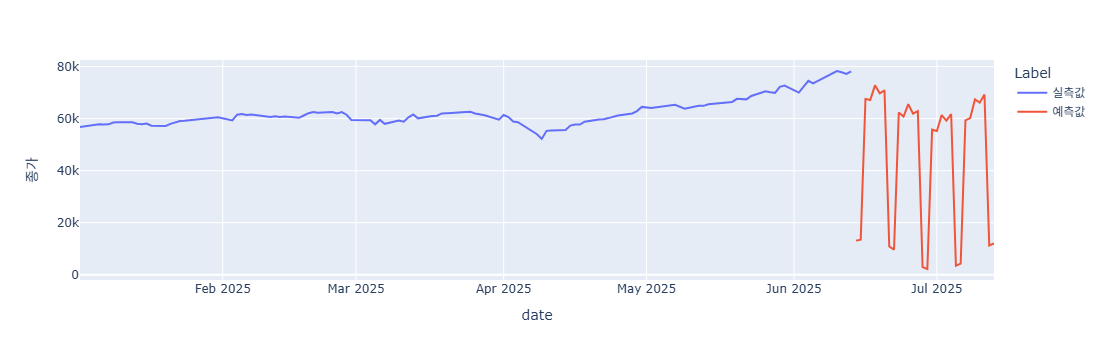

In [135]:
p4 = forecast_ets.to_dataframe().reset_index()
p4['Label'] = '예측값'
p5 = pd.concat([df_hana, p4])
px.line(p5, x = 'date', y = '종가', color='Label')

In [127]:
# 평가
ets_model.fit(train, future_covariates=cov)
forecast = ets_model.predict(len(test), future_covariates=cov)
print(mse(test, forecast))
print(rmse(test, forecast))

386520684.0737196
19660.12929951682


### theta model

- theta 모형: 시계열 데이터의 트랜드와 계절성을 효과적으로 포착하는 간단하면서 강력한 모델
- 특히 단기 예측과 추세가 존재하는 시계열에서 좋은 성능을 보임
- theta 모형은 시계열 데이터를 두개의 theta line components(세타 선형 성분)분해하여, 각각의 성분에 대해 예측을 수행한뒤, 이를 재 조합하여 최종 예측을 수행
- 평활 성분: 단순 지수 평활법(simple exponential smoothing)을 적용하여, 시계열의 변동성을 제거하고 추세를 따로 추출한 성분
- 추세 성분: 시계열의 추세를 나타내는 성분을 따로 추출
- 선형적 특성 뿐만 아니라, 비선형적 특성도 일부 포착이 가능한 모형
- ETS모델보다 비교적 간단하면서 naive모델보다 복잡성을 가진 높은 성능의 모델로 평가
- theta 계수: 시계열의 선형성을 변형시키는 역할
  - theta = 0: 데이터의 평균 수준을 반영
  - theta > 1: 추세가 더욱 강조된 데이터, 데이터의 장기적인 패턴을 잘 반영
  - theta < 1: 변동성이 강조된 데이터, 단기적인 변동에 대해 반영, 단기예측
- 단점:
  - y값이 음수값인 경우 계산이 불가능, 시계열 데이터를 변환을 통해, 음수값을 제거한 뒤 모델을 구성

In [128]:
from darts.models import Theta

theta_model = Theta(theta=0.5)
theta_model.fit(series1)

Theta(theta=0.5, seasonality_period=None, season_mode=SeasonalityMode.MULTIPLICATIVE)

In [129]:
forecast_theta = theta_model.predict(30)
p6 = forecast_theta.to_dataframe().reset_index()
p6['label'] = '예측값'

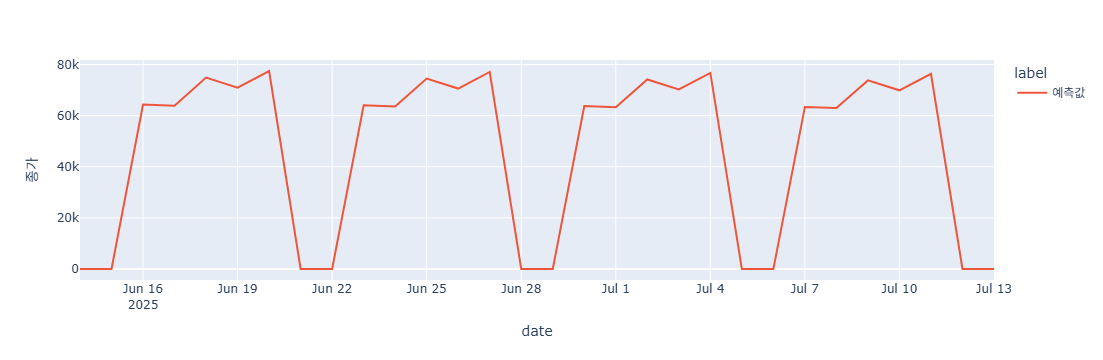

In [136]:
p7 = pd.concat([df_hana, p6])
px.line(p7, x = 'date', y = '종가', color='label')

In [137]:
theta_model.fit(train)
forecast = theta_model.predict(len(test))
print(mse(test, forecast))
print(rmse(test, forecast))

531290416.82409567
23049.737890572545


**Grid Search 기법을 활용해 적정 theta 값 도출**

In [138]:
# mape(mean absolute percentage error)
# 실제값과 예측값 간의 오차를 백분율로 계산
# mape =5%: 모델의 예측값이 실제값과 평균적으로 5%정도 차이난다는 의미
from darts.metrics import mape

In [142]:
# 0보다 크고 3보다 작은 약 30개의 데이터를 생성하여, 각 theta값에 대한 mape를 계산
theta_list = np.linspace(0.01, 3, 30)

# 최적의 mape값을 찾기 위해, 초기 mape값을 큰값으로 설정
best_mape = float('inf')

# 최적의 mape값이 계산될 때, theta값을 저장하기 위한 변수 설정
best_theta = 0

# 반복문을 이용해 theta값을 돌아가면서 모데에 입력
for i in theta_list:
    theta_loop_model = Theta(theta = i)#  앞서 선언된 theta list값을 반복적으로 바귀어 가며 모델 구성
    theta_loop_model.fit(train)
    forecast_loop = theta_loop_model.predict(len(test)) #mape를 계산하기 위한 예측값 계산
    model_mape = mape(test, forecast_loop)# mape값

    # 현재 등장한 mape값이 기존의 mape보다 더 낮은 mape값이 도출
    if best_mape > model_mape:
        best_mape = model_mape
        best_theta = i

print(best_theta, best_mape)

0.01 292807.4349609455


In [143]:
# 6. 25년도 2,3월 대비 4,5월에 거래량의 평균의 차이가 있는지 검정 하시오 .

df_hana['거래량'].isnull().sum()

0

In [144]:
stats.normaltest(df_hana['거래량'])

NormaltestResult(statistic=23.760402251253733, pvalue=6.926186910031808e-06)

In [146]:
df_hana[['시가', '고가', '저가', '거래량', '종가']].corr(method='spearman')['거래량']

시가     0.079093
고가     0.108267
저가     0.063973
거래량    1.000000
종가     0.057984
Name: 거래량, dtype: float64

In [149]:
# 귀무가설: 거래량과 해당 연속형 자료는 서로 상관성이 없다.
# 대립가설: 거래량과 해당 연속형 자료는 서로 상관성이 있다. 
for name in ['시가', '고가', '저가', '종가']:
    print(stats.spearmanr(df_hana['거래량'], df_hana[name]))
# 귀무가설 참 -> 상관성이 없다.

SignificanceResult(statistic=0.0790927246811926, pvalue=0.4180541518419325)
SignificanceResult(statistic=0.10826685407210349, pvalue=0.26698457789519764)
SignificanceResult(statistic=0.06397295789081178, pvalue=0.5126995830648935)
SignificanceResult(statistic=0.05798422110491766, pvalue=0.5530151728433547)


In [151]:
# 7. 거래량과 종가/시가/고가/저가에 상관성이 있는지 검정 하시오. 

cond1 = df_hana['month'].isin([2, 3])
cond2 = df_hana['month'].isin([4, 5])
df0203 = df_hana.loc[cond1]
df0405 = df_hana.loc[cond2]

In [152]:
print(stats.normaltest(df0203['거래량']))
print(stats.normaltest(df0405['거래량']))

NormaltestResult(statistic=7.45511784785445, pvalue=0.024051475717273993)
NormaltestResult(statistic=21.845142259426517, pvalue=1.8046277453584806e-05)


In [153]:
# 귀무가설: 중앙값이 서로 같다
# 대립가설: 중앙값이 서로 다르다
stats.ranksums(df0203['거래량'], df0405['거래량'])
# 중앙값이 서로 같다

RanksumsResult(statistic=1.1713413047066334, pvalue=0.24146161498185414)

In [134]:
# 8. 앞서 1번에서 수집 된 데이터의 날짜의 Lag를 3일로 지정하여, 이전 3일 주가로 다음을 예측하는 모형을 Ensemble 알고리즘 중 하나를 활용하여 구성하시오.